<a href="https://colab.research.google.com/github/linfrick/dip_learners/blob/main/Linda_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14 dicembre
I'm trying to replicate what was done here: https://keras.io/examples/timeseries/timeseries_weather_forecasting/

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/dip_learners_folder2

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1TAc4mTQBgA9Db7CkATIg6BYoQuhlOTPb/dip_learners_folder2


In [2]:
### IMPORTARE LIBRERIE GIUSTE E GUARDARE ELENCO SU CODALAB


seed = 2

# Reduce randomness as much as possible
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import random
random.seed(seed)

import numpy as np
np.random.seed(seed)

import tensorflow as tf
tf.random.set_seed(seed)


# Import other libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

from sklearn.model_selection import train_test_split
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Bidirectional

import matplotlib.pyplot as plt

# Load the data

In [3]:
categories = np.load('categories.npy', allow_pickle=True)
training_data = np.load('training_data.npy', allow_pickle=True)
valid_periods = np.load('valid_periods.npy', allow_pickle=True)

print(categories.shape)
print(training_data.shape)
print(valid_periods.shape)

(48000,)
(48000, 2776)
(48000, 2)


# Inspect the data

In [4]:
# 6 different categories

# The division into categories may help you to choose the best strategy for
# implementing your model (or possibly your group of models).
# Also remember that time series can have very different lengths

# IMPORTANT: This is a dataset consisting of monovariate time series, i.e.
# composed of a single feature, belonging to six different domains. The time
# series of each domain are not to be understood as closely related to each
# other, but only as collected from similar data sources.
# What is required of you is therefore to build a model that is capable of
# generalising sufficiently to predict the future samples of the 60 time series
# of the test set.

np.unique(categories)

array(['A', 'B', 'C', 'D', 'E', 'F'], dtype='<U1')

In [5]:
# Each row of the dataset corresponds to a feature and time independent time series.
# Each row of the dataset has been normalised to the range [0,1] independently of the other rows.
# (PS: remember to de-normalise in the prediction function)

print(training_data)

[[0.         0.         0.         ... 0.60277778 0.36759259 0.33148148]
 [0.         0.         0.         ... 0.6        0.46       0.396     ]
 [0.         0.         0.         ... 0.96048126 0.94650625 0.97714021]
 ...
 [0.         0.         0.         ... 0.52631579 0.58223684 0.55263158]
 [0.         0.         0.         ... 0.44559585 0.58549223 0.40414508]
 [0.         0.         0.         ... 0.54268293 0.6097561  0.59146341]]


In [6]:
# Remember that time series can have very different lengths.

print(valid_periods)

[[2325 2776]
 [2325 2776]
 [2325 2776]
 ...
 [2676 2776]
 [2676 2776]
 [2676 2776]]


In [7]:
# Do all valid periods end with 2776? Yes.
print(valid_periods[valid_periods[:,1]==2776,:].shape)

print(valid_periods[valid_periods[:,1]==2776,:])

(48000, 2)
[[2325 2776]
 [2325 2776]
 [2325 2776]
 ...
 [2676 2776]
 [2676 2776]
 [2676 2776]]


In [8]:
# Do all valid periods start before 2500? No.
print(valid_periods[valid_periods[:,0]<2500,:].shape)

print(valid_periods[valid_periods[:,0]>=2500,:])

(14878, 2)
[[2712 2776]
 [2682 2776]
 [2682 2776]
 ...
 [2676 2776]
 [2676 2776]
 [2676 2776]]


In [9]:
int(random.random()*training_data.shape[0])

45889

In [10]:
length = 0
for i in range(valid_periods.shape[0]):
  start,end = valid_periods[i]
  length += (end-start)
length /= valid_periods.shape[0]
print("Average length: "+str(length))

Average length: 198.30022916666667


In [11]:
training_data[29123, 2488:2776]

array([1.        , 0.98939929, 0.98586572, 0.89399293, 0.89045936,
       0.88339223, 0.86219081, 0.86925795, 0.85865724, 0.82685512,
       0.85512367, 0.86219081, 0.91166078, 0.8975265 , 0.91166078,
       0.88339223, 0.86219081, 0.84805654, 0.795053  , 0.76678445,
       0.74558304, 0.74204947, 0.71024735, 0.70318021, 0.74204947,
       0.73498233, 0.74558304, 0.72791519, 0.70671378, 0.71024735,
       0.72084806, 0.70671378, 0.69964664, 0.68551237, 0.66431095,
       0.64310954, 0.5795053 , 0.5795053 , 0.58657244, 0.57243816,
       0.56183746, 0.56183746, 0.5335689 , 0.51236749, 0.50530035,
       0.57243816, 0.56537102, 0.56183746, 0.5335689 , 0.51590106,
       0.52650177, 0.5335689 , 0.52650177, 0.51943463, 0.51943463,
       0.5229682 , 0.52650177, 0.50176678, 0.50883392, 0.51590106,
       0.51590106, 0.50883392, 0.51943463, 0.51943463, 0.50883392,
       0.51590106, 0.49469965, 0.51236749, 0.51590106, 0.48409894,
       0.48056537, 0.50176678, 0.49823322, 0.50883392, 0.53710

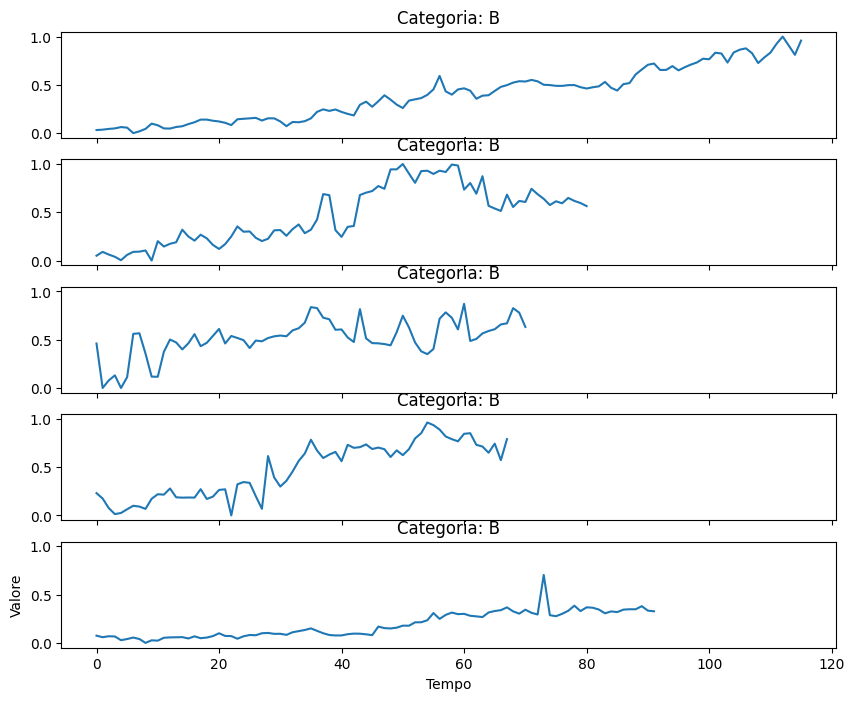

In [12]:
# Visualizza alcune serie temporali
num_time_series_to_plot = 5
range_start = int( random.random()*(training_data.shape[0]-num_time_series_to_plot) )
range_end = range_start+num_time_series_to_plot
fig, axs = plt.subplots(num_time_series_to_plot, figsize=(10, 8), sharex=True, sharey=True)

for i in range( range_start, range_end ):
    start, end = valid_periods[i]
    axs[i-range_start].plot(training_data[i, start:end])
    axs[i-range_start].set_title(f"Categoria: {categories[i]}")

plt.xlabel("Tempo")
plt.ylabel("Valore")
plt.show()

# Build train e validation
Split all data into sequences with window 200 and telescope 18, using a stride of 50.
Keep categories of each sequence in order to do stratified sampling for train-val split.

In [13]:
def build_sequences(data, window=200, stride=50, telescope=18):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    future = []
    sequence_categories = []

    # For each row, keep only the valid period, pad it and then make sequences
    for idx, row in enumerate(data):
      start_index = valid_periods[idx,0]

      category = categories[idx]


      temp_row = row[start_index:] #keep only valid data of row to create sequences
      padding_check = len(temp_row)%window

      if(padding_check != 0):
          # Compute padding length
          padding_len = window - len(temp_row)%window
          padding = np.zeros(padding_len, dtype='float32')
          temp_row = np.concatenate((padding,temp_row))
          assert len(temp_row) % window == 0


      for i in np.arange(0, len(temp_row) - window - telescope, stride):
          dataset.append(temp_row[i:i + window]) #qui c'era .tolist() prima, in caso serva
          future.append(temp_row[i+window:i+window+telescope])
          sequence_categories.append(category)


    dataset = np.array(dataset)
    future = np.array(future)
    sequence_categories = np.array(sequence_categories)

    return dataset, future, sequence_categories

In [14]:
X, y, cat = build_sequences(training_data)
print(X.shape, y.shape, cat.shape)

(107724, 200) (107724, 18) (107724,)


In [15]:
# Split sequences with stratified sampling
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=cat, random_state=42)

# Build model

In [16]:
input_shape =  (X_train.shape[1], 1)
output_shape = (y_train.shape[1], 1)
print(input_shape, output_shape)

(200, 1) (18, 1)


In [17]:
inputs = tfk.layers.Input(shape=(input_shape))
conv_out = Conv1D(32, kernel_size=3, activation='relu')(inputs)
lstm_out = tfk.layers.LSTM(64)(conv_out)
outputs = tfk.layers.Dense(18)(lstm_out)
# Create the model
model = Model(inputs=inputs, outputs=outputs)


In [18]:
learning_rate = 0.001

# Compile the model
model.compile(optimizer=tfk.optimizers.Adam(learning_rate=learning_rate), loss="mse")

# Display the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 198, 32)           128       
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 18)                1170      
                                                                 
Total params: 26130 (102.07 KB)
Trainable params: 26130 (102.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


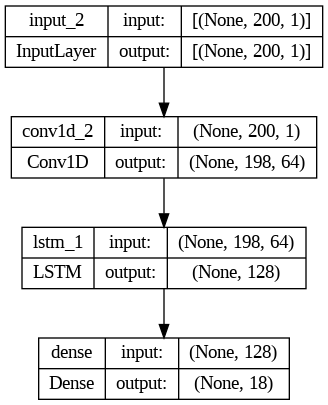

In [ ]:
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [19]:
batch_size = 32
epochs = 30

path_checkpoint = "model_checkpoint.weights.h5"
es_callback = tfk.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

modelckpt_callback = tfk.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(X_val, y_val),
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/30
2694/2694 [==============================] - ETA: 0s - loss: 0.0135
Epoch 1: val_loss improved from inf to 0.01119, saving model to model_checkpoint.weights.h5
2694/2694 [==============================] - 37s 11ms/step - loss: 0.0135 - val_loss: 0.0112
Epoch 2/30
2690/2694 [============================>.] - ETA: 0s - loss: 0.0110
Epoch 2: val_loss improved from 0.01119 to 0.01038, saving model to model_checkpoint.weights.h5
2694/2694 [==============================] - 27s 10ms/step - loss: 0.0110 - val_loss: 0.0104
Epoch 3/30
2691/2694 [============================>.] - ETA: 0s - loss: 0.0104
Epoch 3: val_loss improved from 0.01038 to 0.00997, saving model to model_checkpoint.weights.h5
2694/2694 [==============================] - 28s 10ms/step - loss: 0.0104 - val_loss: 0.0100
Epoch 4/30
2692/2694 [============================>.] - ETA: 0s - loss: 0.0100
Epoch 4: val_loss did not improve from 0.00997
2694/2694 [==============================] - 26s 10ms/step - loss: 0.0100 

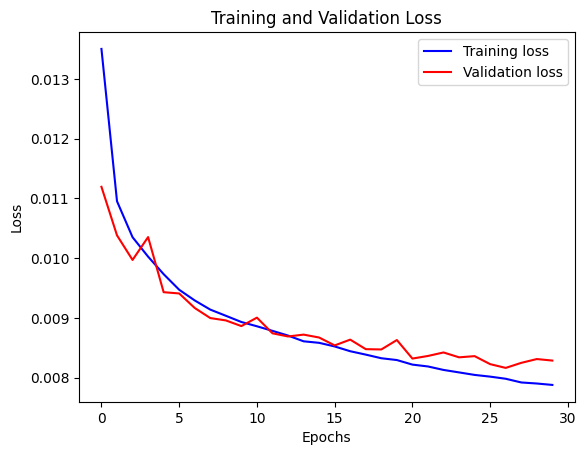

In [20]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

To check if the shape of the prediction is [BSx9] and see MSE and MAE of the model (on the validation set)

In [21]:
# Predict the test set using the model
predictions = model.predict(X_val, verbose=0)
#predictions = np.reshape(predictions, (-1,18,0))
# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_val.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_val.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (21545, 18)
Mean Squared Error: 0.008283616043627262
Mean Absolute Error: 0.05956177040934563


In [22]:
model.save('linda_lstm_cnn')